# Cylindrical Magneto-Coriolis Modes 

This notebook builds a complete symbolic-to-numerical pipeline to compute linear **magneto-Coriolis modes** in a rotating cylinder using a **toroidal–poloidal** formulation. Velocity and magnetic perturbations are expanded as Fourier modes $e^{i(k z + m\varphi - \omega t)}$ with radial amplitudes defined by the potentials $(T,P)$ for the flow and $(G,F)$ for the magnetic field. With SageMath’s differential operators in cylindrical coordinates, we construct the linearized momentum and induction equations, and assemble a coupled radial system for $[T,P,G,F]^T$. Boundary conditions at the cylinder radius $s=a$ are imposed by matching the interior field to an exterior current-free field $\boldsymbol B_{\text{ext}}=-\nabla\Phi$. The resulting problem is a generalized eigenvalue problem, which is solved numerically (SciPy) to obtain radial eigenvalues and associated spectra $\omega\,(m, n, k)$. The notebook outputs the eigenvalues/vectors, derived quantities, and plots, providing reproducible workflow for exploring rotating MHD waves in cylindrical geometry.

## 1. Definitions

In [1]:
version()

'SageMath version 10.2, Release Date: 2023-12-03'

In [2]:
%display latex 

In [3]:
E.<s,ph,z> = EuclideanSpace(coordinates='cylindrical')
print(E)
E

Euclidean space E^3


Euclidean space E^3

In [4]:
var('k');
var('m');
var('ω');
var('Omega');
var('t');
var('B0');
var('a');
var('mu');
var('rho');
var('C1');

In [8]:
e_s=E.cylindrical_frame()[1]
e_ph=E.cylindrical_frame()[2]
e_z=E.cylindrical_frame()[3]

### Toroidal - Poloidal Fields

In [9]:
T = E.scalar_field(function('T')(s)*exp(I*k*z)*exp(I*m*ph)*exp(I*ω*t), name='T')
T.display()

T: E^3 → ℝ
   (s, ph, z) ↦ T(s)*e^(I*m*ph + I*k*z + I*t*ω)

In [10]:
G = E.scalar_field(function('G')(s)*exp(I*k*z)*exp(I*m*ph)*exp(I*ω*t), name='G')
G.display()

G: E^3 → ℝ
   (s, ph, z) ↦ G(s)*e^(I*m*ph + I*k*z + I*t*ω)

In [11]:
P = E.scalar_field(function('P')(s)*exp(I*k*z)*exp(I*m*ph)*exp(I*ω*t), name='P')
P.display()

P: E^3 → ℝ
   (s, ph, z) ↦ P(s)*e^(I*m*ph + I*k*z + I*t*ω)

In [12]:
F = E.scalar_field(function('F')(s)*exp(I*k*z)*exp(I*m*ph)*exp(I*ω*t), name='F')
F.display()

F: E^3 → ℝ
   (s, ph, z) ↦ F(s)*e^(I*m*ph + I*k*z + I*t*ω)

In [13]:
from sage.manifolds.operators import *
from sage.manifolds.operators import grad

## 2. Hydrodynamic

### Velocity field

In [14]:
v= curl(T*e_s) + curl(curl(P*e_s))
v.display()

curl(T*e_s)+curl(curl(P*e_s)) = (k^2*s^2*e^(I*m*ph) + m^2*e^(I*m*ph))*P(s)*e^(I*k*z + I*t*ω)/s^2 e_s + (I*k*s^2*T(s)*e^(I*m*ph) + I*m*s*e^(I*m*ph)*d(P)/ds - I*m*P(s)*e^(I*m*ph))*e^(I*k*z + I*t*ω)/s^2 e_ph + (I*k*s*e^(I*m*ph)*d(P)/ds + I*k*P(s)*e^(I*m*ph) - I*m*T(s)*e^(I*m*ph))*e^(I*k*z + I*t*ω)/s e_z

 \begin{align}
    v_s &= \left( k^2 P(s) + \frac{m^2}{s^2}P(s) \right) e^{i(kz + m\varphi + \omega t)}  \\
    v_{\varphi} &= \left(ik T(s) + \frac{im}{s}\frac{\partial P}{\partial s} - \frac{im}{s^2}P(s) \right) e^{i(kz + m\varphi + \omega t)} \\
    v_z &= \left( ik \frac{\partial P}{\partial s} + \frac{ik}{s}P(s) - \frac{im}{s}T(s) \right) e^{i(kz + m\varphi + \omega t)}
\end{align}

In [15]:
dt_v = I*ω*v
dt_v.display()

(I*k^2*s^2*e^(I*m*ph) + I*m^2*e^(I*m*ph))*ω*P(s)*e^(I*k*z + I*t*ω)/s^2 e_s - (k*s^2*T(s)*e^(I*m*ph) + m*s*e^(I*m*ph)*d(P)/ds - m*P(s)*e^(I*m*ph))*ω*e^(I*k*z + I*t*ω)/s^2 e_ph - (k*s*e^(I*m*ph)*d(P)/ds + k*P(s)*e^(I*m*ph) - m*T(s)*e^(I*m*ph))*ω*e^(I*k*z + I*t*ω)/s e_z

### Navier-Stokes equations

In [12]:
NS_vec = dt_v + 2*Omega*e_z.cross(v)
NS_vec.display()

((I*k^2*s^2*e^(I*m*ph) + I*m^2*e^(I*m*ph))*ω*P(s)*e^(I*k*z) - 2*(I*Omega*k*s^2*T(s)*e^(I*m*ph) + I*Omega*m*s*e^(I*m*ph)*d(P)/ds - I*Omega*m*P(s)*e^(I*m*ph))*e^(I*k*z))*e^(I*t*ω)/s^2 e_s - ((k*s^2*T(s)*e^(I*m*ph) + m*s*e^(I*m*ph)*d(P)/ds - m*P(s)*e^(I*m*ph))*ω*e^(I*k*z) - 2*(Omega*k^2*s^2*e^(I*m*ph) + Omega*m^2*e^(I*m*ph))*P(s)*e^(I*k*z))*e^(I*t*ω)/s^2 e_ph - (k*s*e^(I*m*ph)*d(P)/ds + k*P(s)*e^(I*m*ph) - m*T(s)*e^(I*m*ph))*ω*e^(I*k*z + I*t*ω)/s e_z

In [13]:
NS_1 = e_s.dot(curl(NS_vec))
NS_1.display()

E^3 → ℝ
(s, ph, z) ↦ -((2*I*k*m*P(s)*e^(I*m*ph) + (-I*k^2*s^2*e^(I*m*ph) - I*m^2*e^(I*m*ph))*T(s))*ω*e^(I*k*z) + 2*(I*Omega*k^3*s^2*e^(I*m*ph) + I*Omega*k*m^2*e^(I*m*ph))*P(s)*e^(I*k*z))*e^(I*t*ω)/s^2

In [14]:
NS_2 = e_s.dot(curl(curl(NS_vec)))
NS_2.display()

E^3 → ℝ
(s, ph, z) ↦ ((-2*I*k*m*s^2*T(s)*e^(I*m*ph) + (I*k^4*s^4*e^(I*m*ph) + (2*I*k^2*m^2 + I*k^2)*s^2*e^(I*m*ph) + (I*m^4 - I*m^2)*e^(I*m*ph))*P(s) + (-I*k^2*s^3*e^(I*m*ph) + I*m^2*s*e^(I*m*ph))*d(P)/ds + (-I*k^2*s^4*e^(I*m*ph) - I*m^2*s^2*e^(I*m*ph))*d^2(P)/ds^2)*ω*e^(I*k*z) + 2*(2*I*Omega*k^2*m*s^2*P(s)*e^(I*m*ph) + (-I*Omega*k^3*s^4*e^(I*m*ph) - I*Omega*k*m^2*s^2*e^(I*m*ph))*T(s))*e^(I*k*z))*e^(I*t*ω)/s^4

### Eigenvalue system

In [15]:
NS_1_eq = (NS_1.expr() == 0)*exp(-I*k*z)*exp(-I*m*ph)*exp(-I*ω*t)*s**2
NS_1_eq.full_simplify().show()

(-2*I*k*m*P(s) + (I*k^2*s^2 + I*m^2)*T(s))*ω + 2*(-I*Omega*k^3*s^2 - I*Omega*k*m^2)*P(s) == 0

In [16]:
NS_2_eq = (NS_2.expr() == 0)*exp(-I*k*z)*exp(-I*m*ph)*exp(-I*ω*t)*s**2
NS_2_eq.full_simplify().show()

(4*I*Omega*k^2*m*s^2*P(s) + (-2*I*k*m*s^2*T(s) - (-I*k^4*s^4 - I*m^4 + (-2*I*k^2*m^2 - I*k^2)*s^2 + I*m^2)*P(s) - (I*k^2*s^3 - I*m^2*s)*diff(P(s), s) - (I*k^2*s^4 + I*m^2*s^2)*diff(P(s), s, s))*ω - 2*(I*Omega*k^3*s^4 + I*Omega*k*m^2*s^2)*T(s))/s^2 == 0

\begin{equation}
A(s) \begin{bmatrix}
T(s) \\
P(s) \end{bmatrix} 
= \omega B(s)
\begin{bmatrix}
T(s) \\
P(s) \end{bmatrix}
\end{equation}


\begin{equation}
\begin{bmatrix}
0 & -2(i \Omega k^3 s^2 + i \Omega k m^2) \\
-2(i \Omega k^{3} s^{2} + i \Omega k m^{2}) & -4i \Omega k^2 m \\
\end{bmatrix}
\begin{bmatrix}
T(s) \\
P(s) \end{bmatrix}
= \omega 
\begin{bmatrix}
i(k^2 s^2 + m^2) & 2 i k m \\
2 i k m &
\dfrac{-(-i k^4 s^4 - i m^4 + (-2 i k^2 m^2 - i k^2) s^2 + i m^2) - (i k^2 s^3 - i m^2 s) \dfrac{\partial}{\partial s} - (i k^2 s^4 + i m^2 s^2) \dfrac{\partial ^2}{\partial s^2}}{s^2}
\end{bmatrix}
\begin{bmatrix}
T(s) \\
P(s) \end{bmatrix}
\end{equation}


## 3. Greenspan's solution : $B_0 = 0$

We need to find the solutions $\xi$ of the equation:
\begin{equation}
    \xi\frac{d}{d\xi}J_{\lvert m \rvert}(\xi) + m\left( 1 + \frac{\xi^2 h^2}{n_{ax}^2\pi^2 a^2}\right)^{1/2} J_{\lvert m \rvert}(\xi) = 0
\end{equation}
With the corresponding eigenvalues : 
\begin{equation}
    \lambda_{knm} = 2 \left( 1 + \frac{\xi^2_{knm}h^2}{n_{ax}^2\pi^2 a^2}\right)^{-1/2}
\end{equation}

#### Numerical resolution of Greenspan's equation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv, jvp
from scipy.optimize import root_scalar

# Function to solve
def equation(xi):
    Jm = jv(abs(m), xi)
    dJm_dxi = jvp(abs(m), xi, n=1)
    factor = np.sqrt(1 + (xi**2 * h**2) / (n_axial**2 * np.pi**2 * a**2))
    return xi * dJm_dxi + m * factor * Jm

# Searching for roots
xi_vals = np.linspace(0.0001, 200, 1000)
f_vals = [equation(xi) for xi in xi_vals]

# Plots
plt.figure(figsize=(8, 4))
plt.plot(xi_vals, f_vals)
plt.axhline(0, color='gray', linestyle='-.')
plt.xlabel(r"$\xi$")
plt.ylabel(r"$f(\xi)$")
plt.title(rf"Pour $k={k:.3}$, $m={m}$, $n={n_axial}$, $h={h}$")
plt.grid(True)
plt.show()

# Roots detection
roots = []
for i in range(len(xi_vals) - 1):
    if f_vals[i] * f_vals[i+1] < 0:
        try:
            sol = root_scalar(equation, bracket=[xi_vals[i], xi_vals[i+1]], method='brentq')
            roots.append(sol.root)
        except:
            pass

# lambda_{knm} calculation
def lambda_knm(xi):
    return 2 / np.sqrt(1 + (xi**2 * h**2) / (n_axial**2 * np.pi**2 * a**2))

roots = roots[:50]  # 50 first values
lambdas = [lambda_knm(xi) for xi in roots]

# Results
print("\nValeurs de ξ et λ correspondantes :")
for i, (xi_val, lambda_val) in enumerate(zip(roots[:5], lambdas[:5])):
    print(rf"ξ_{i+1} = {xi_val:.6f}   ->   λ_{i+1} = {lambda_val:.6f}")


## 4. Magnetohydrodynamic

### Magnetic field

In [19]:
b = curl(G*e_s) + curl(curl(F*e_s))
b.display()

curl(G*e_s)+curl(curl(F*e_s)) = (k^2*s^2*e^(I*m*ph) + m^2*e^(I*m*ph))*F(s)*e^(I*k*z + I*t*ω)/s^2 e_s + (I*k*s^2*G(s)*e^(I*m*ph) + I*m*s*e^(I*m*ph)*d(F)/ds - I*m*F(s)*e^(I*m*ph))*e^(I*k*z + I*t*ω)/s^2 e_ph + (I*k*s*e^(I*m*ph)*d(F)/ds + I*k*F(s)*e^(I*m*ph) - I*m*G(s)*e^(I*m*ph))*e^(I*k*z + I*t*ω)/s e_z

In [20]:
b_s = e_s.dot(b)
b_s.display()

e_s.curl(G*e_s)+curl(curl(F*e_s)): E^3 → ℝ
   (s, ph, z) ↦ (k^2*s^2*e^(I*m*ph) + m^2*e^(I*m*ph))*F(s)*e^(I*k*z + I*t*ω)/s^2

In [20]:
dt_b = I*ω*b

In [21]:
dt_b_s = e_s.dot(dt_b)
dt_b_s.display()

E^3 → ℝ
(s, ph, z) ↦ (I*k^2*s^2*e^(I*m*ph) + I*m^2*e^(I*m*ph))*ω*F(s)*e^(I*k*z + I*t*ω)/s^2

### Equations of motion

#### Magnetic tension

We need to calculate $\nabla \times (ikB_0 \vec{b})\lvert_s$ and $\nabla \times (\nabla \times ikB_0 \vec{b})\lvert_s$ to add to the N-S equations.

In [34]:
MHD_1 = NS_1 - (1/mu*rho)*e_s.dot(curl(I*k*B0*b))

In [37]:
MHD_1_eq = (MHD_1.expr() == 0)*exp(-I*k*z)*exp(-I*m*ph)*exp(-I*ω*t)*s**2
MHD_1_eq.full_simplify().show()

(2*I*B0*k^2*m*rho*F(s) + (-2*I*k*m*mu*P(s) + (I*k^2*mu*s^2 + I*m^2*mu)*T(s))*ω + (-I*B0*k^3*rho*s^2 - I*B0*k*m^2*rho)*G(s) + 2*(-I*Omega*k^3*mu*s^2 - I*Omega*k*m^2*mu)*P(s))/mu == 0

In [35]:
MHD_2 = NS_2 - (1/mu*rho)*e_s.dot(curl(curl(I*k*B0*b)))

In [38]:
MHD_2_eq = (MHD_2.expr() == 0)*exp(-I*k*z)*exp(-I*m*ph)*exp(-I*ω*t)*s**2
MHD_2_eq.full_simplify().show()

(2*I*B0*k^2*m*rho*s^2*G(s) + 4*I*Omega*k^2*m*mu*s^2*P(s) + (-2*I*k*m*mu*s^2*T(s) - (-I*k^4*mu*s^4 + (-2*I*k^2*m^2 - I*k^2)*mu*s^2 + (-I*m^4 + I*m^2)*mu)*P(s) - (I*k^2*mu*s^3 - I*m^2*mu*s)*diff(P(s), s) - (I*k^2*mu*s^4 + I*m^2*mu*s^2)*diff(P(s), s, s))*ω - (I*B0*k^5*rho*s^4 + (2*I*B0*k^3*m^2 + I*B0*k^3)*rho*s^2 + (I*B0*k*m^4 - I*B0*k*m^2)*rho)*F(s) - 2*(I*Omega*k^3*mu*s^4 + I*Omega*k*m^2*mu*s^2)*T(s) - (-I*B0*k^3*rho*s^3 + I*B0*k*m^2*rho*s)*diff(F(s), s) - (-I*B0*k^3*rho*s^4 - I*B0*k*m^2*rho*s^2)*diff(F(s), s, s))/(mu*s^2) == 0

### Ideal induction

\begin{equation}
    \frac{\partial}{\partial t}\vec{b}  = \left( \vec{B}_0 \cdot \nabla\right)\vec{v}
\end{equation}

In [23]:
Ind_1 = e_s.dot(dt_b - B0*I*k*v)
Ind_1.display()

E^3 → ℝ
(s, ph, z) ↦ ((I*k^2*s^2*e^(I*m*ph) + I*m^2*e^(I*m*ph))*ω*F(s)*e^(I*k*z) + (-I*B0*k^3*s^2*e^(I*m*ph) - I*B0*k*m^2*e^(I*m*ph))*P(s)*e^(I*k*z))*e^(I*t*ω)/s^2

In [29]:
Ind_1_eq = (Ind_1.expr() == 0)*exp(-I*k*z)*exp(-I*m*ph)*exp(-I*ω*t)*s**2
Ind_1_eq.full_simplify().show()

(I*k^2*s^2 + I*m^2)*ω*F(s) + (-I*B0*k^3*s^2 - I*B0*k*m^2)*P(s) == 0

In [24]:
Ind_2 = e_s.dot(curl(dt_b - B0*I*k*v))
Ind_2.display()

E^3 → ℝ
(s, ph, z) ↦ -((2*I*k*m*F(s)*e^(I*m*ph) + (-I*k^2*s^2*e^(I*m*ph) - I*m^2*e^(I*m*ph))*G(s))*ω*e^(I*k*z) + (-2*I*B0*k^2*m*P(s)*e^(I*m*ph) + (I*B0*k^3*s^2*e^(I*m*ph) + I*B0*k*m^2*e^(I*m*ph))*T(s))*e^(I*k*z))*e^(I*t*ω)/s^2

In [31]:
Ind_2_eq = (Ind_2.expr() == 0)*exp(-I*k*z)*exp(-I*m*ph)*exp(-I*ω*t)*s**2
Ind_2_eq.full_simplify().show()

2*I*B0*k^2*m*P(s) + (-2*I*k*m*F(s) + (I*k^2*s^2 + I*m^2)*G(s))*ω + (-I*B0*k^3*s^2 - I*B0*k*m^2)*T(s) == 0

### Eigenvalue system

\begin{equation}
\mathcal{A(s)} \begin{bmatrix}
T(s) \\
P(s) \\
G(s) \\
F(s)
\end{bmatrix} 
= \omega \mathcal{B(s)}
\begin{bmatrix}
T(s) \\
P(s) \\
G(s) \\
F(s)
\end{bmatrix}
\end{equation}


\begin{equation}
\begin{bmatrix}
0 & -2 i \Omega k (k^2 s^2 + m^2) & - i B_0 \rho k (k^2 s^2 + m^2) & + 2 i B_0 k^2 m \rho \\
0 & 4 i \Omega k^2 m & \frac{1}{\mu s^2} 2 i B_0 k^2 m \rho s^2 & \frac{-1}{\mu s^2} \left(i B_0 k^5 \rho s^4 + (2 i B_0 k^3 m^2 + i B_0 k^3) \rho s^2 + (i B_0 k m^4 - i B_0 k m^2) \rho\right) + \frac{-1}{\mu s^2} \left(-i B_0 k^3 \rho s^3 + i B_0 k m^2 \rho s\right) \frac{d}{ds} + \frac{-1}{\mu s^2} \left(-i B_0 k^3 \rho s^4 - i B_0 k m^2 \rho s^2\right) \frac{d^2}{ds^2} \\
0 & -i B_0 k (k^2 s^2 + m^2) & 0 & 0 \\
-i B_0 k (k^2 s^2 + m^2) & 2 i B_0 k^2 m & 0 & 0
\end{bmatrix}
\begin{bmatrix}
T(s) \\
P(s) \\
G(s) \\
F(s)
\end{bmatrix}
= \omega 
\begin{bmatrix}
i (k^2 s^2 + m^2) & -2 i k m & 0 & 0\\
-2 i k m & i \left(k^4 s^2 + (2k^2 m^2 + k^2) + m^4 - m^2\right) -(i k^2 s + i m^2 1/s) \frac{d}{ds} - (i k^2 s^2 + i m^2) \frac{d^2}{ds^2} & 0 & 0 \\
0 & 0 & 0 & i (k^2 s^2 + m^2) \\
0 & 0 & i (k^2 s^2 + m^2) & -2 i k m
\end{bmatrix}
\begin{bmatrix}
T(s) \\
P(s) \\
G(s) \\
F(s)
\end{bmatrix}
\end{equation}

### Boundary conditions :

A magnetic flux tube is surrounded by an external magnetic field $\mathbf{B}_{ext}$, which can be assumed to be derived from a potential of the same form as toroidal-poloidal fields. That is, we have 
\begin{equation}
    \mathbf{B}_{ext} = - \nabla \Phi \,\ \text{where} \,\ \Phi = \tilde{\Phi}(s) e^{i(m\varphi + kz + \omega t)}
\end{equation}
Where $\tilde{\Phi}$ is again the Fourier amplitude. Since $\nabla \cdot \mathbf{B} = 0$, we can solve
\begin{equation}
    \nabla^2 \Phi = 0
\end{equation}
such that 
\begin{equation}
    \Phi = C_1 Y_m (-iks) e^{i(m \varphi + kz + \omega t)}
\end{equation}

In [24]:
bs = e_s.dot(b)*exp(-I*k*z)*exp(-I*m*ph)*exp(-I*ω*t)*s**2
bs.expr().full_simplify().show()

(k^2*s^2 + m^2)*F(s)

In [50]:
bph = e_ph.dot(b)*exp(-I*k*z)*exp(-I*m*ph)*exp(-I*ω*t)*s**2
bph.expr().full_simplify().show()

I*k*s^2*G(s) + I*m*s*diff(F(s), s) - I*m*F(s)

In [26]:
bz = e_z.dot(b)*exp(-I*k*z)*exp(-I*m*ph)*exp(-I*ω*t)*s**2
bz.expr().full_simplify().show()

I*k*s^2*diff(F(s), s) + I*k*s*F(s) - I*m*s*G(s)

In [1]:
F_1, dF_1, G_1, k, m, C = var('F_1 dF_1 G_1 k m C')

In [2]:
Phi = function('Phi')(s)
Phi == C1*bessel_Y(m,-I*k*s)

Phi(s) == C1*bessel_Y(m, -I*k*s)

In [73]:
eq_s = bs + C1*Phi.diff(s)
eq1 = (eq_s.expr() == 0)
eq1.show()

(k^2*s^2 + m^2)*F(s) + C1*diff(Phi(s), s) == 0

In [17]:
F_1 == -(C/(k**2 + m**2))*diff(bessel_Y(m,-(I*k)*s),s)

F_1 == -1/2*I*C*k*(bessel_Y(m + 1, -I*k*s) - bessel_Y(m - 1, -I*k*s))/(k^2 + m^2)

In [18]:
dF_1 == -(C/(k**2 + m**2))*diff(bessel_Y(m,-(I*k)*s),s) - C*(bessel_Y(m,-(I*k)*s))

dF_1 == -1/2*I*C*k*(bessel_Y(m + 1, -I*k*s) - bessel_Y(m - 1, -I*k*s))/(k^2 + m^2) - C*bessel_Y(m, -I*k*s)

In [74]:
eq_ph = bph + I*m*C1*Phi.diff(s)
eq2 = (eq_ph.expr() == 0)
eq2.show()

I*k*s^2*G(s) + I*m*s*diff(F(s), s) + I*C1*m*diff(Phi(s), s) - I*m*F(s) == 0

In [75]:
eq_z = bz + I*m*C1*Phi.diff(s)
eq3 = (eq_z.expr() == 0)
eq3.show()

I*k*s^2*diff(F(s), s) + I*k*s*F(s) - I*m*s*G(s) + I*C1*m*diff(Phi(s), s) == 0

## 5. Lundquist's solution : m = 0, $\Omega = 0$

For $m=0$ and $\Omega \to 0$, the governing equations reduce to Lundquist’s ideal-MHD model for a cylindrical plasma column. In this model, the radial equation for the perturbation \(h(s)\) reads
\begin{equation}
\frac{\partial^2 h}{\partial s^2} + \frac{1}{s} \frac{\partial h}{\partial s} + \left(k^2 - \frac{1}{s^2}\right) h = 0,
\end{equation}
whose regular solution at \(s=0\) is
\begin{equation}
h(s,t,z) = A\, J_1(k s) \, e^{i\omega t + i\alpha z}.
\end{equation}
In the absence of rotation, two independent families of modes exist :

**Radial modes :** Obtained from the boundary condition \(h(a)=0\), which leads to 
\begin{equation}
    J_1(k_r a) = 0 \Rightarrow k_r = \frac{j_{1,n}}{a}
\end{equation}
so that
\begin{equation}
    \omega_{n}^{(\pm)} = \pm\, V_A\, k_r
\end{equation}
**Axial modes :** For which 
\begin{equation}
    k_r=0 \,\ ; k_z =\frac{n_{\rm axial} \pi}{h}
\end{equation}
giving 
\begin{equation}
    \omega_{n_{\rm axial}}^{(\pm)} = \pm\, V_A\, k_z.
\end{equation}

In [22]:
N_l = 10

# Alfvén speed
V_a = B0 / np.sqrt(mu0 * rho)

# Zeros of J1
j1_zeros = np.array([float(mp.besseljzero(1, n)) for n in range(1, N_l + 1)])

# Axial wavenumber
k_z = (np.pi / h) * np.arange(1, N_l + 1, dtype=float)

# Eigenfrequencies
omega_L_rad = V_a * j1_zeros / a      # radial Lundquist
omega_L_ax  = V_a * k_z               # axial Alfvén

# previous code results for m = 0 and _rad : \Omega = 1 ; _ax : \Omega = 0
omega_MCWS_rad = np.array([3.83492, 7.19234, 10.39528, 13.55841, 16.70897,
                           19.85460, 22.99808, 26.14051, 29.28247, 32.42410], dtype=float)
omega_MCWS_ax  = np.array([3.14159, 6.28319, 9.42478, 12.56637, 15.70796,
                           18.84957, 21.99115, 25.13277, 28.27434, 31.41593], dtype=float)

print(f"Ideal MHD (Lundquist) eigenfrequencies :")
print(" " * 67)
print(f"Alfvén speed V_A = {float(V_a):.1f}\n")
print(" " * 67)
print(r"|   n |  omega_L_rad |omega_MCWS_rad|   omega_L_ax | omega_MCWS_ax|")
print("-" * 67)
for n, olr, omr, ola, oma in zip(range(1, N_l + 1), omega_L_rad, omega_MCWS_rad, omega_L_ax, omega_MCWS_ax):
    print(f"| {n:3d} | {float(olr):12.6f} | {float(omr):12.6f} | {float(ola):12.6f} | {float(oma):12.6f} |")

# Check d’erreur
abs_err_rad = omega_MCWS_rad - omega_L_rad
abs_err_ax  = omega_MCWS_ax  - omega_L_ax
print("\nMAE_rad = {:.3e}, MAE_ax = {:.3e}".format(np.mean(np.abs(abs_err_rad)), np.mean(np.abs(abs_err_ax))))


Ideal MHD (Lundquist) eigenfrequencies :
                                                                   
Alfvén speed V_A = 1.0

                                                                   
|   n |  omega_L_rad |omega_MCWS_rad|   omega_L_ax | omega_MCWS_ax|
-------------------------------------------------------------------
|   1 |     3.831706 |     3.834920 |     3.141593 |     3.141590 |
|   2 |     7.015587 |     7.192340 |     6.283185 |     6.283190 |
|   3 |    10.173468 |    10.395280 |     9.424778 |     9.424780 |
|   4 |    13.323692 |    13.558410 |    12.566371 |    12.566370 |
|   5 |    16.470630 |    16.708970 |    15.707963 |    15.707960 |
|   6 |    19.615859 |    19.854600 |    18.849556 |    18.849570 |
|   7 |    22.760084 |    22.998080 |    21.991149 |    21.991150 |
|   8 |    25.903672 |    26.140510 |    25.132741 |    25.132770 |
|   9 |    29.046829 |    29.282470 |    28.274334 |    28.274340 |
|  10 |    32.189680 |    32.424100 |    31.415927 

## 6. Cylindrical Magneto-Coriolis Waves Solver

-------------------------------------------------------------------
                  Cylindrical Magneto-Coriolis Waves           
-------------------------------------------------------------------
Top 5 eigenvalues for (m, n) = (3, 2) :
1. Re(ω) = 7.09419, Im(ω) = 1.37240e-10
2. Re(ω) = 6.89876, Im(ω) = -3.18560e-10
3. Re(ω) = 6.76792, Im(ω) = 1.96384e-10
4. Re(ω) = 6.67933, Im(ω) = 1.51615e-10
5. Re(ω) = 6.61673, Im(ω) = -4.45089e-10


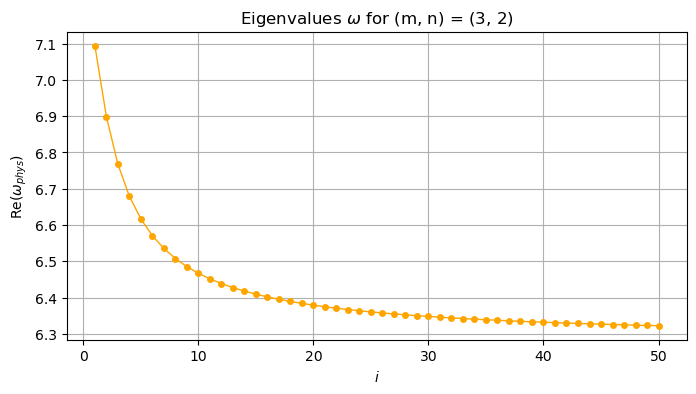

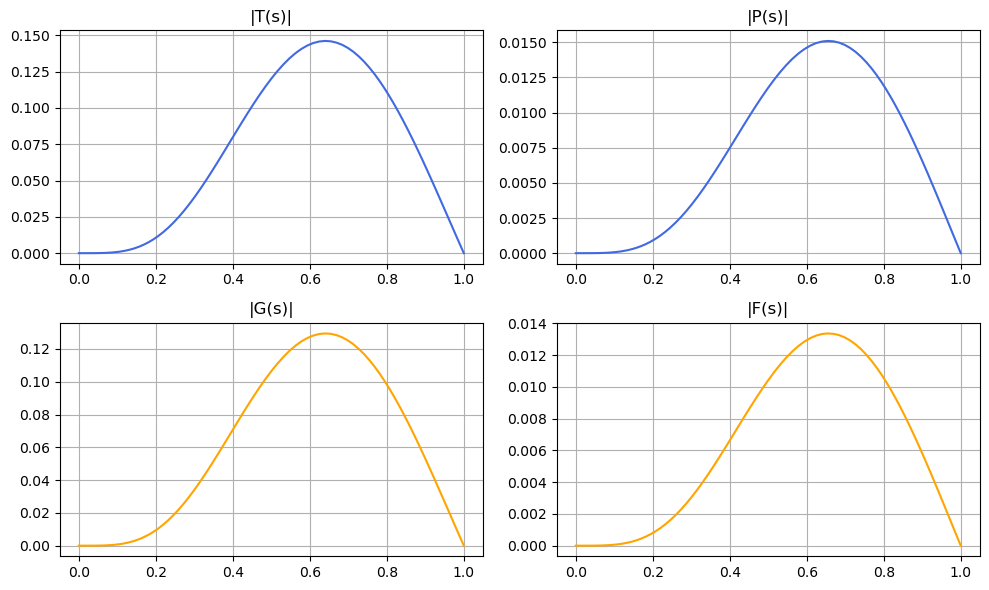

In [23]:
# === USEFUL PACKAGES ===
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from scipy.linalg import eig
from scipy.special import yv, jv, jvp
from scipy.optimize import root_scalar
from scipy.interpolate import griddata

# === PHYSICAL SITUATION ===
solve_mhd = True # True : MHD, False : fluid (B0 = 0)
solve_Lundquist = False # True : m = 0 

if solve_mhd == True : 
    if solve_Lundquist == True :
        print("-" * 67)
        print("                    Cylindrical-Alfvèn Waves           ")
        print("-" * 67)
    else : 
        print("-" * 67)
        print("                  Cylindrical Magneto-Coriolis Waves           ")
        print("-" * 67)
else : 
    print("-" * 67)
    print("                    Cylindrical-Inertial Waves           ")
    print("-" * 67)
    
# === PHYSICAL PARAMETERS ===
h = 1
a = 1
n_axial = 2
Omega_mass = 1
Omega_rot = 0 if solve_Lundquist else Omega_mass
mu0 = 1
rho = 1
m_az = 3
B0 = 1 if solve_mhd else 0
m = 0 if solve_Lundquist else m_az
k = (n_axial * np.pi) / h
C = 1 # pour le champ extérieur
phi_indices = [0,50]
times = [1]

# === Solution Greenspan ===
# Fonction à résoudre
def equation(xi):
    Jm = jv(abs(m), xi)
    dJm_dxi = jvp(abs(m), xi, n=1)
    factor = np.sqrt(1 + (xi**2 * h**2) / (n_axial**2 * np.pi**2 * a**2))
    return xi * dJm_dxi + m * factor * Jm

# Recherche des racines
xi_vals = np.linspace(0.0001, 200, 1000)
f_vals = [equation(xi) for xi in xi_vals]

# Roots of the function 
roots = []
for i in range(len(xi_vals) - 1):
    if f_vals[i] * f_vals[i+1] < 0:
        try:
            sol = root_scalar(equation, bracket=[xi_vals[i], xi_vals[i+1]], method='brentq')
            roots.append(sol.root)
        except:
            pass

# lambda_{knm}
def lambda_knm(xi):
    return 2 / np.sqrt(1 + (xi**2 * h**2) / (n_axial**2 * np.pi**2 * a**2))

roots = roots[:50]  # 50 premières valeurs
lambdas = [lambda_knm(xi) for xi in roots]

# === Solution de Lundquist ===
if solve_Lundquist:
    N_l = 10
    
    # Alfvén speed
    V_a = B0 / np.sqrt(mu0 * rho)

    # Zeros of J1
    j1_zeros = np.array([float(mp.besseljzero(1, n)) for n in range(1, N_l + 1)])

    # Axial wavenumber
    k_z = (np.pi / h) * np.arange(1, N_l + 1, dtype=float)

    # Eigenfrequencies
    omega_L_rad = V_a * j1_zeros / a      # radial Lundquist
    omega_L_ax  = V_a * k_z               # axial Alfvén
else : 
    pass

# === CHEBYSHEV MATRIX ===
def cheb_diff(N):
    if N == 0:
        return np.array([[0]]), np.array([1])
    x = -np.cos(np.pi * np.arange(N + 1) / N) # points sur [-1, 1] (ordre croissant, d'où le signe -)
    
    # Chebyshev coefficients 
    c = np.ones(N + 1)
    c[0], c[-1] = 2, 2
    c *= (-1) ** np.arange(N + 1)
    
    # Computation of matrix D
    X = np.tile(x, (N + 1, 1)).T
    dX = X - X.T + np.eye(N + 1)
    D = (np.outer(c, 1 / c)) / dX
    D -= np.diag(np.sum(D, axis=1))
    
    # s s on [0, 1]
    s = 0.5 * (x + 1)
    
    return 2 * D, s

# === DISCRÉTISATION ===
N = 100
D, s = cheb_diff(N)
D2 = D @ D
n_p = N + 1
size = 4 * n_p

T_idx = np.arange(0, n_p)
P_idx = np.arange(n_p, 2 * n_p)
G_idx = np.arange(2 * n_p, 3 * n_p)
F_idx = np.arange(3 * n_p, 4 * n_p)

A = np.zeros((size, size), dtype=complex)
B = np.zeros((size, size), dtype=complex)

# === SYSTEM ===
for j, sj in enumerate(s):
    
    # Equation 1 (curl of the motion eq., radial projection)
    row = j
    A[row, P_idx[j]] = -2j * Omega_rot * (k**3 * sj**2 + k * m**2)
    A[row, G_idx[j]] = -1j * B0 / (mu0 * rho) * (k**3 * sj**2 + k * m**2)
    A[row, F_idx[j]] = -2j * B0 / (mu0 * rho) * (k**2 * m)
    B[row, T_idx[j]] = 1j * Omega_mass * (k**2 * sj**2 + m**2)
    B[row, P_idx[j]] = 2j * Omega_mass * k * m
    
    # Equation 2 (double curl of the motion eq., radial projection)
    row = n_p + j
    A[row, T_idx[j]] = 2j * Omega_rot * (k**3 * sj**4 + k * m**2 * sj**2)
    A[row, P_idx[j]] = 4j * Omega_rot * (k**2 * m * sj**2)
    A[row, G_idx[j]] = 2j * B0 / (mu0 * rho) * (k**2 * m * sj**2)
    coef0_F = 1j * B0 / (mu0 * rho) * (k**5 * sj**4 + k**3 * (2 * m**2 + 1) * sj**2 + k * (m**4 - m**2))
    coef1_F = 1j * B0 / (mu0 * rho) * (-k**3 * sj**3 + k * m**2 * sj)
    coef2_F = -1j * B0 / (mu0 * rho) * (k**3 * sj**4 + k * m**2 * sj**2)
    A[row, F_idx] += coef0_F * np.eye(n_p)[j] + coef1_F * D[j] + coef2_F * D2[j]
    B[row, T_idx[j]] = -2j * Omega_mass * (k * m * sj**2)
    coef0_P = 1j * Omega_mass * ((m**2 - m**4) - (2 * m**2 + 1) * k**2 * sj**2 - k**4 * sj**4)
    coef1_P = 1j * Omega_mass * (k**2 * sj**3 - m**2 * sj)
    coef2_P = 1j * Omega_mass * (k**2 * sj**4 + m**2 * sj**2)
    B[row, P_idx] += coef0_P * np.eye(n_p)[j] + coef1_P * D[j] + coef2_P * D2[j]
    
    # Equation 3 (induction equation, radial projection)
    row = 2 * n_p + j
    A[row, P_idx[j]] = -1j * B0 / (mu0 * rho) * (k**3 * sj**2 + k * m**2)
    B[row, F_idx[j]] = 1j * (k**2 * sj**2 + m**2)

    # Equation 4 (curl of induction equation, radial projection)
    row = 3 * n_p + j
    A[row, T_idx[j]] = 1j * B0 / (mu0 * rho) * (k**3 * sj**2 + k * m**2)
    A[row, P_idx[j]] = 2j * B0 / (mu0 * rho) * (k**2 * m)
    B[row, G_idx[j]] = -1j * (k**2 * sj**2 + m**2)
    B[row, F_idx[j]] = -2j * k * m

# === BOUNDARY CONDITIONS ===
# Match with B_ext
def compute_F1_dF1_G1(m, k, C):
    F1 = ((-1j*C*k)/2*(k**2 + m**2)) * (yv(m + 1, -1j * k) - yv(m - 1, -1j * k))
    dF1 = F1 - C * yv(m, -1j * k)
    G1 = 0
    return F1, dF1, G1

F1_val, dF1_val, G1_val = compute_F1_dF1_G1(m, k, C)

# Condition in s=0 : P(0)=0 or dP(0)=0 regarding m
if m == 0 or m % 2 == 1:
    A[P_idx[0], :] = 0
    A[P_idx[0], P_idx[0]] = 1
    B[P_idx[0], :] = 0
else:
    A[P_idx[0], :] = 0
    A[P_idx[0], P_idx] = D[0, :]
    B[P_idx[0], :] = 0
    
A[P_idx[-1], :] = 0
A[P_idx[-1], P_idx[-1]] = 1
B[P_idx[-1], :] = 0

if solve_mhd :
    A[G_idx[-1], :] = 0
    A[G_idx[-1], G_idx[-1]] = 1
    B[G_idx[-1], :] = 0

    A[F_idx[-1], :] = 0
    A[F_idx[-1], F_idx[-1]] = 1
    B[F_idx[-1], :] = 0
    B[F_idx[-1], F_idx[-1]] = F1_val
else : 
    pass

# === SYSTEM SOLVING ===
omega_all, VEP_all = eig(A, B)
mask = np.isfinite(omega_all) & (np.abs(omega_all.imag) < 1e-2)
omega = omega_all[mask]
VEP = VEP_all[:, mask]

# === SOLUTION DOMINANTE ===
idc_dom = np.argsort(-omega.real)
omega_phys = omega[idc_dom]
top_omegas = omega_phys[:50]
u_dom = VEP[:, idc_dom[0]]
u_total = u_dom

T_vec = u_total[T_idx]
P_vec = u_total[P_idx]
G_vec = u_total[G_idx]
F_vec = u_total[F_idx]

# === AFFICHAGE DES RÉSULTATS ===
#### Greenspan if Fluid case ####
if solve_mhd == False : 
    # Affichage des résultats
    print("Greenspan's eigenvalues vs MCWS : ")
    print(" " * 67)
    for i, (xi_val, lambda_val, omega_val) in enumerate(zip(roots[:5], lambdas[:5], top_omegas[:5]) ):
        print(rf"ξ_{i+1} = {xi_val:.5f}   ->   λ_{i+1} = {lambda_val:.5f} | Re(ω)_{i+1} = {omega_val.real:.5f}")
    print(" " * 67)    
    # Comparaison with Greenspan's eigenvalues for Hydro
    plt.figure(figsize=(8, 3))
    plt.scatter(np.arange(len(roots)), lambdas, marker='_',label='Greenspan')
    plt.scatter(np.arange(len(top_omegas)), np.real(top_omegas), marker='.',label='Chebychev')
    plt.xlabel(r"$i$", fontsize=12)
    plt.ylabel(r"$\lambda_{knm}$ - Re$(\omega_{phys})$", fontsize=12)
    plt.title(rf" Greenspan's $\lambda$ vs MCWS's $\omega$ pour $n={n_axial}$, $m={m}$")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Error 
    error = np.abs(lambdas - top_omegas)
    MSE = np.real(np.square(np.subtract(lambdas,top_omegas)).mean())
    print(f"MSE = {MSE:.4}")
    print(" " * 67)
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 2, 1)
    plt.plot(s, np.abs(T_vec),color = 'royalblue'); plt.title("|T(s)|"); plt.grid()
    plt.subplot(2, 2, 2)
    plt.plot(s, np.abs(P_vec),color = 'royalblue'); plt.title("|P(s)|"); plt.grid()
else : 
    #### Lundquist ####
    if solve_Lundquist :
        # previous code results
        omega_MCWS_rad = np.array([3.83492, 7.19234, 10.39528, 13.55841, 16.70897,
                                   19.85460, 22.99808, 26.14051, 29.28247, 32.42410], dtype=float)
        omega_MCWS_ax  = np.array([3.14159, 6.28319, 9.42478, 12.56637, 15.70796,
                                   18.84957, 21.99115, 25.13277, 28.27434, 31.41593], dtype=float)

        print(f"Ideal MHD (Lundquist) eigenfrequencies :")
        print(" " * 67)
        print(f"Alfvén speed V_A = {float(V_a):.1f}\n")
        print(" " * 67)
        print(r"|   n |  omega_L_rad |omega_MCWS_rad|   omega_L_ax | omega_MCWS_ax|")
        print("-" * 67)
        for n, olr, omr, ola, oma in zip(range(1, N_l + 1), omega_L_rad, omega_MCWS_rad, omega_L_ax, omega_MCWS_ax):
            print(f"| {n:3d} | {float(olr):12.6f} | {float(omr):12.6f} | {float(ola):12.6f} | {float(oma):12.6f} |")

        # Check d’erreur
        abs_err_rad = omega_MCWS_rad - omega_L_rad
        abs_err_ax  = omega_MCWS_ax  - omega_L_ax
        print("\nMAE_rad = {:.3e}, MAE_ax = {:.3e}".format(np.mean(np.abs(abs_err_rad)), np.mean(np.abs(abs_err_ax))))
    
    #### MHD GENERAL ####
    else : 
        print(f"Top 5 eigenvalues for (m, n) = ({m}, {n_axial}) :")
        for i, val in enumerate(top_omegas[:5]):
            print(rf"{i+1}. Re(ω) = {val.real:.5f}, Im(ω) = {val.imag:.5e}")
        plt.figure(figsize=(8, 4))
        plt.plot(range(1,51), np.real(omega_phys[:50]), '.-', 
                 linewidth='1', markeredgewidth=2, color = 'orange' if solve_mhd else 'royalblue')
        plt.xlabel(r"$i$")
        plt.ylabel(r"Re$(\omega_{phys})$")
        plt.title(rf"Eigenvalues $\omega$ for (m, n) = ({m}, {n_axial})")
        plt.grid(True)
        plt.show()
        
        # Eigenvectors
        plt.figure(figsize=(10, 6))
        plt.subplot(2, 2, 1)
        plt.plot(s, np.abs(T_vec),color = 'royalblue'); plt.title("|T(s)|"); plt.grid()
        plt.subplot(2, 2, 2)
        plt.plot(s, np.abs(P_vec),color = 'royalblue'); plt.title("|P(s)|"); plt.grid()
        plt.subplot(2, 2, 3)
        plt.plot(s, np.abs(G_vec),color = 'orange'); plt.title("|G(s)|"); plt.grid()
        plt.subplot(2, 2, 4)
        plt.plot(s, np.abs(F_vec),color = 'orange'); plt.title("|F(s)|"); plt.grid()
        plt.tight_layout()
        plt.show()
